In [1]:
from dotenv import load_dotenv
load_dotenv('../.env')

True

In [2]:
from ultralytics import YOLO
from PIL import Image
import torch
import numpy as np

In [10]:
model = YOLO(r"..\models\best.pt").model

In [12]:
isinstance(model,torch.nn.Module)

True

In [3]:
model = YOLO(r"..\models\best.pt")

In [40]:
results = model.predict(r"D:\savmap_dataset_v2\images_splits\00a033fefe644429a1e0fcffe88f8b39_0.JPG",
                        iou=0.5,
                        imgsz=1280,
                        save_crop=False,
                        show_conf=True,
                        show_labels=True,
                        save=True)


image 1/1 D:\savmap_dataset_v2\images_splits\00a033fefe644429a1e0fcffe88f8b39_0.JPG: 1280x1280 919.3ms
Speed: 13.5ms preprocess, 919.3ms inference, 15.5ms postprocess per image at shape (1, 3, 1280, 1280)
Results saved to runs\obb\predict


In [29]:
results = model.predict(r"D:\savmap_dataset_v2\images_splits\00a033fefe644429a1e0fcffe88f8b39_1.JPG",
                        iou=0.5,
                        imgsz=1280,
                        save_crop=False,
                        show_conf=True,
                        show_labels=False,
                        save=True)


image 1/1 D:\savmap_dataset_v2\images_splits\00a033fefe644429a1e0fcffe88f8b39_1.JPG: 1280x1280 903.9ms
Speed: 25.9ms preprocess, 903.9ms inference, 0.0ms postprocess per image at shape (1, 3, 1280, 1280)
Results saved to runs\obb\predict


In [30]:
results[0]

ultralytics.engine.results.Results object with attributes:

boxes: None
keypoints: None
masks: None
names: {0: 'wildlife'}
obb: ultralytics.engine.results.OBB object
orig_img: array([[[ 94, 130, 136],
        [101, 137, 143],
        [107, 143, 149],
        ...,
        [ 85, 128, 137],
        [ 83, 126, 135],
        [ 77, 120, 129]],

       [[ 93, 129, 135],
        [100, 136, 142],
        [108, 144, 150],
        ...,
        [ 81, 124, 133],
        [ 80, 123, 132],
        [ 77, 120, 129]],

       [[ 93, 129, 135],
        [ 98, 134, 140],
        [106, 142, 148],
        ...,
        [ 80, 121, 130],
        [ 83, 126, 135],
        [ 84, 127, 136]],

       ...,

       [[110, 162, 208],
        [114, 166, 212],
        [116, 167, 210],
        ...,
        [100, 135, 169],
        [ 93, 128, 162],
        [ 85, 120, 154]],

       [[ 97, 149, 195],
        [ 92, 144, 190],
        [ 88, 140, 186],
        ...,
        [ 90, 125, 159],
        [ 89, 124, 158],
        [ 88,

In [41]:
results[0].path

'D:\\savmap_dataset_v2\\images_splits\\00a033fefe644429a1e0fcffe88f8b39_0.JPG'

In [42]:
results[0].obb.conf[0].item()

0.44669947028160095

In [43]:
results[0].obb.xyxy.cpu().numpy().tolist()

[[539.0369873046875, 1043.8746337890625, 571.065185546875, 1067.8726806640625]]

In [ ]:
def yolo_results_to_coco(results,is_yolo_obb:bool=True):

    if not is_yolo_obb:
        raise NotImplementedError("Supports only yolo-obb")
    
    coordinates = results.obb.xyxy.cpu().numpy().tolist()
    coco_results = list()

    for (x_min,y_min,x_max,y_max) in coordinates:
        
        template = {'image_id': None,
                 'bbox': [x_min, y_min, x_max-x_min, y_max-y_min], 
                 'score': results.obb.conf[0].item(),
                  'category_id': 0, 
                  'category_name': 'wildlife', 
                  'segmentation': [], 
                  'iscrowd': 0, 
                  'area': None}
        coco_results.append(template)
    
    return coco_results

obb_results_to_coco(results=results[0])
    

[{'image_id': None,
  'bbox': [539.0369873046875,
   1043.8746337890625,
   32.0281982421875,
   23.998046875],
  'score': 0.44669947028160095,
  'category_id': 0,
  'category_name': 'wildlife',
  'segmentation': [],
  'iscrowd': 0,
  'area': None}]

YOLOv8m-obb summary: 320 layers, 26,417,494 parameters, 0 gradients, 81.2 GFLOPs
torch.Size([1, 6, 8400])


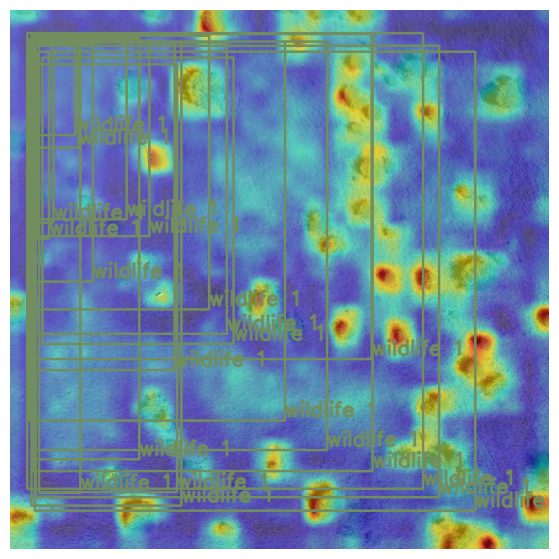

In [2]:
from YOLOv8_Explainer import yolov8_heatmap, display_images
import torch
model = yolov8_heatmap(
    weight=r"..\models\best.pt", 
        conf_threshold=0.4, 
        device = torch.device("cpu"), 
        method = "EigenCAM", 
        layer=[10, 12, 14, 16, 18, -3],
        ratio=0.02,
        show_box=True,
        renormalize=False,
)

imagelist = model(
    img_path=r"D:\savmap_dataset_v2\images_splits\00a033fefe644429a1e0fcffe88f8b39_0.JPG", 
    )

display_images(imagelist)


In [ ]:
import shap
from ultralytics import YOLO

# Load the YOLOv8 segmentation model
model = YOLO("path_to_file.pt")

def yolo_predict(images):
    # Ensure the input is in the correct format for YOLOv8
    images = [np.array(image) for image in images]
    results = model(images)
    # Extract the segmentation masks or other relevant outputs
    masks = [result.masks for result in results]
    return np.array(masks)

# Create a masker for the images
masker = shap.maskers.Image("inpaint_telea", (640, 640, 3))

# Create an explainer using the custom prediction function
explainer = shap.Explainer(yolo_predict, masker)

# Select an image to explain
image_path = r"path_to_image.png"
img = Image.open(image_path)
img = img.resize((640, 640))
image = np.array(img)
image_with_batch = np.expand_dims(image, axis=0)
print(image_with_batch.shape)

# Generate SHAP values
shap_values = explainer(image_with_batch, max_evals=20, outputs=shap.Explanation.argsort.flip[:1])

# Visualize the explanation
shap.image_plot(shap_values, image_with_batch)